<a href="https://colab.research.google.com/github/jinglescode/python-signal-processing/blob/main/tutorials/Canonical%20Correlation%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Canonical Correlation Analysis

In this tutorial, we will learn how we can use canonical correlation analysis to find similarity between 2 signals.

## Load packages

We will download splearn, a package that consists of datasets, common signal processing functions and machine learning model architectures.

In [1]:
#@title 
!git clone https://github.com/jinglescode/python-signal-processing.git
%cd python-signal-processing
!pip install -r requirements.txt --quiet

Cloning into 'python-signal-processing'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 75 (delta 35), reused 42 (delta 13), pack-reused 0
Unpacking objects: 100% (75/75), done.
/content/python-signal-processing


In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from splearn.data.generate import generate_signal # https://github.com/jinglescode/python-signal-processing/blob/main/splearn/data/generate.py
from splearn.cross_decomposition.cca import * # https://github.com/jinglescode/python-signal-processing/blob/main/splearn/cross_decomposition/
from splearn.cross_decomposition.reference_frequencies import * # https://github.com/jinglescode/python-signal-processing/blob/main/splearn/cross_decomposition/

# Introduction

[Canonical correlation analysis (CCA)](https://en.wikipedia.org/wiki/Canonical_correlation) is applied to analyze the frequency components of a signal, extracting the narrowband frequency component of the signal. CCA is a multivariable statistical method used when there are two sets of data may have some underlying correlation. CCA finds a pair of linear combinations, called canonical variables, such that the correlation between the two canonical variables is maximized. 

We can use CCA for feature extraction and classification, given `X` is the raw signal, and `Y` contains the target frequencies, the frequency with the largest coefficient (maximum correlation between `X` and `Y` ) is the predicted target.


In [3]:
sampling_rate = 250
signal_duration_seconds = 4

## Frequency Component Analysis

CCA works on two sets of variables. 

First is the signals, `X`, in this tutorial we designed the signals to be 3-dimensional with shape `(batch, channel, time)`. 

Second is a periodic signal, a square-wave periodic signal at a certain frequency `f`, which can be decomposed into the Fourier series of its harmonics `(sin(2πf t), cos(2πf t), sin(4πf t), ...)`.

In this tutorial, our target frequencies are:

> 3hz, 8hz, 11hz and 15hz

Our goal is to use CCA to find if the signal contains which of these target frequencies.


In [4]:
target_frequencies = [3,8,11,15]
target_frequencies = np.array(target_frequencies)
reference_frequencies = generate_reference_signals(target_frequencies, size=signal_duration_seconds*sampling_rate, sampling_rate=sampling_rate, num_harmonics=2)

Let's create a 4-seconds signal, `s1`, with a sampling rate of 250. For this example, the target frequency we want to extract is 11hz, thus we have hidden 11hz in this signal. 

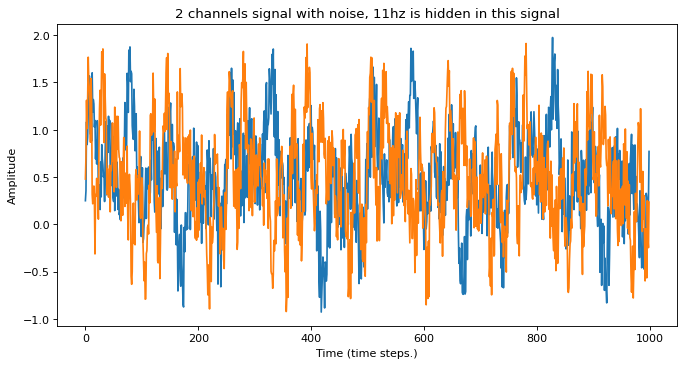

In [5]:
s1_1 = generate_signal(
    length_seconds=signal_duration_seconds, 
    sampling_rate=sampling_rate, 
    frequencies=[1,4,7],  
    add_noise=1,
)

s1_2 = generate_signal(
    length_seconds=signal_duration_seconds, 
    sampling_rate=sampling_rate, 
    frequencies=[2,9,11],  
    add_noise=1,
)

# combine the channels and craete the signal `s1` into shape (batch, channel, time)
s1_1 = np.expand_dims(s1_1, 0)
s1_2 = np.expand_dims(s1_2, 0)
s1 = np.concatenate((s1_1,s1_2),0)
s1 = np.expand_dims(s1, 0)

# plot `s1`
figure(figsize=(10, 5), dpi=80)
plt.plot(s1[0,0,:])
plt.plot(s1[0,1,:])

plt.xlabel('Time (time steps.)')
plt.ylabel('Amplitude')
plt.title('2 channels signal with noise, 11hz is hidden in this signal')
plt.show()

Input the signal `s1`, and the `reference_frequencies` which contains the 4 target frequencies' square-wave periodic signal; we extract the frequency with the largest coefficient.

In [6]:
predicted_class, accuracy, predicted_probabilities = perform_cca(s1, reference_frequencies)
print("Frequency with the largest coefficient is:", target_frequencies[predicted_class][0])

Frequency with the largest coefficient is: 11


We can also get the probabilities for each target. In this example, the third target, which is 11hz, coefficient is 0.521. While the other targets are less than 0.1.

In [7]:
print("Target frequencies sequence: ", target_frequencies)
print("Probabilities:", predicted_probabilities[0])

Target frequencies sequence:  [ 3  8 11 15]
Probabilities: [0.024 0.04  0.521 0.028]


## Perform CCA by batch

As we have designed the `perform_cca` function to accept signals of shape `(batch, channel, time)`, let's create 2 more signals and find the frequency with the largest coefficient for each trial by batch.

Signal #2 target is 3hz. Signal #3 has 2 target frequencies, 8hz and 11hz, channel containing 11hz is a noisier signal.

In [8]:
# create signal 2

s2_1 = generate_signal(
    length_seconds=signal_duration_seconds, 
    sampling_rate=250, 
    frequencies=[1,5],  
    add_noise=1,
)

s2_2 = generate_signal(
    length_seconds=signal_duration_seconds, 
    sampling_rate=250, 
    frequencies=[3,12,21],  
    add_noise=1,
)

s2_1 = np.expand_dims(s2_1, 0)
s2_2 = np.expand_dims(s2_2, 0)
s2 = np.concatenate((s2_1,s2_2),0)
s2 = np.expand_dims(s2, 0)

# create signal 3

s3_1 = generate_signal(
    length_seconds=signal_duration_seconds, 
    sampling_rate=250, 
    frequencies=[1,11],  
    add_noise=2,
)

s3_2 = generate_signal(
    length_seconds=signal_duration_seconds, 
    sampling_rate=250, 
    frequencies=[8,9],  
    add_noise=1,
)

s3_1 = np.expand_dims(s3_1, 0)
s3_2 = np.expand_dims(s3_2, 0)
s3 = np.concatenate((s3_1,s3_2),0)
s3 = np.expand_dims(s3, 0)

# combine s1, s2, s3
signals = np.concatenate((s1,s2,s3),0)
print("Signals shape", signals.shape)

Signals shape (3, 2, 1000)


In [9]:
predicted_class, accuracy, predicted_probabilities = perform_cca(signals, reference_frequencies, labels=None)
print("Frequency with the largest coefficient is:", target_frequencies[predicted_class])

Frequency with the largest coefficient is: [11  3  8]


Here, we can see the 3 frequencies with the largest coefficient, the first trial is 11hz, second is 3hz, and third is 8hz. Despite that the third signal `s3` containing 2 targets frequencies, 8hz has higher coefficient than 11hz. We can verify that by looking at the probabilities.

In [10]:
print("Target frequencies sequence: ", target_frequencies)
print("Probabilities:")
predicted_probabilities

Target frequencies sequence:  [ 3  8 11 15]
Probabilities:


[array([0.024, 0.04 , 0.521, 0.028]),
 array([0.476, 0.052, 0.058, 0.049]),
 array([0.041, 0.596, 0.507, 0.029])]